# Notes
We reproduce the SCAL approach in [1]. We compare our results with that in [1].

[1] Gordon V. Cormack and Maura R. Grossman. 2016. Scalability of Continuous Active Learning for Reliable High- Recall Text Classification. In Proceedings of the 25th ACM International on Conference on Information and Knowledge Management (Indianapolis, Indiana, USA) (CIKM ’16). ACM, New York, NY, USA, 1039–1048.



In [1]:
import os
import re
import glob
import subprocess
import pandas as pd
from IPython.display import Image

In [2]:
root_dir = os.path.abspath('../..')
tar_master_dir = os.path.join(root_dir, 'tar-master')
data_dir = os.path.join(root_dir, 'baseline_reproduction', 'scal', 'data')
ret_dir = os.path.join(root_dir, 'baseline_reproduction', 'scal', 'ret')

athome1_topics = [
"athome100",
"athome101",
"athome102",
"athome103",
"athome104",
"athome105",
"athome106",
"athome107",
"athome108",
"athome109",
]

# Results in paper [1]

- The following two tables are from paper [1].
- We hope to achieve the similar recall of 0.90 and screen effort of 9504 on the `athome1` dataset.

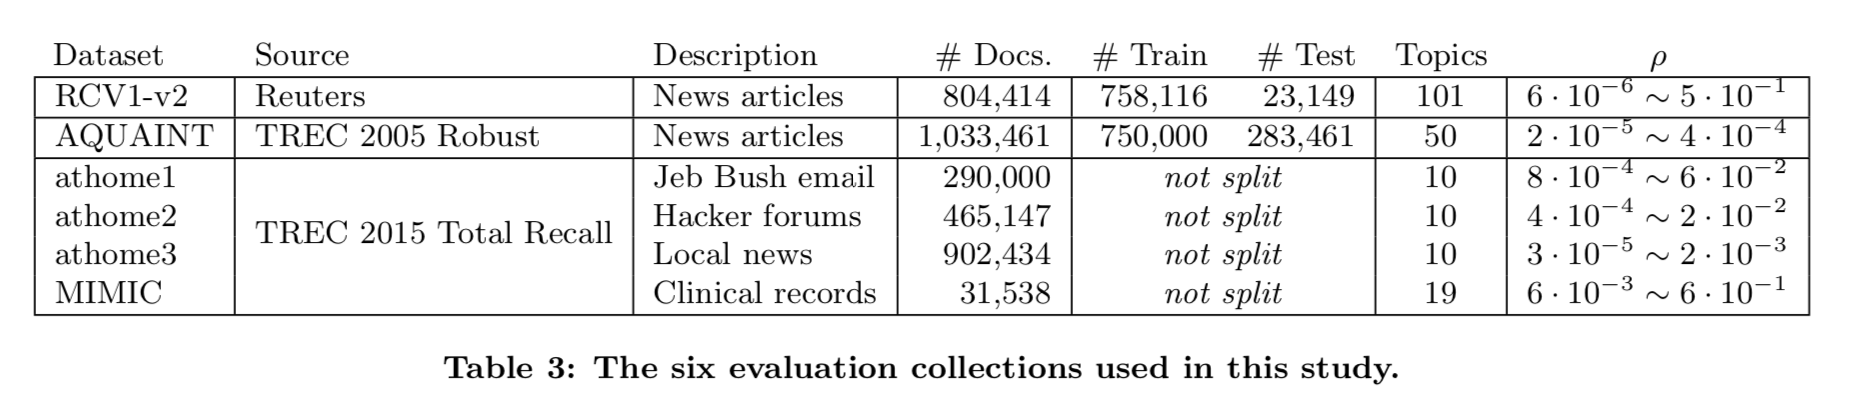

In [3]:
Image(filename='./images/table3.png', width=800)

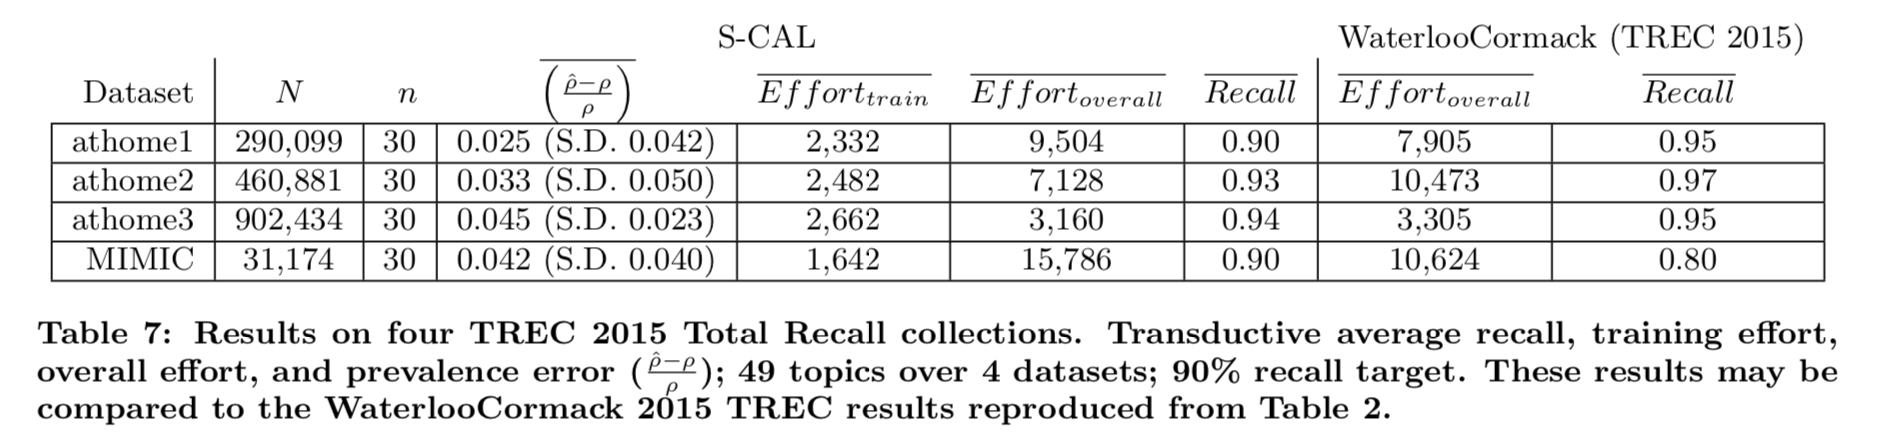

In [4]:
Image(filename='./images/table7.png', width=800)

# Reproduce SCAL

- We reproduce SCAL on the `athome1` dataset.
    
- We sweep all the hyper-parameters in order to reproduce the result as close as possible.

- Hyper-parameters include `sub_percentage`, `bound_bt`, and `ita`. Note that in the implementation of SCAL, we allows to test `max_or_min` and `bucket_type` in order to testify our guess of the implementation of SCAL.
- The best hyper-parameter configuration(`sub_percentage=1.0, bound_bt=110, ita=1.05`) leads to recall of 0.91 and number of screened documents of 13198, where the metrics are 0.90 and 9504 in the original SCAL paper.

In [5]:
def check_file(filepath):
    if not os.path.exists(filepath):
        print('not existing file {}'.format(filepath))
    if os.path.getsize(filepath) == 0:
        print('zero byte file {}'.format(filepath))


def tar_eval(model_name, topic_id):
    
    # run file
    runfile = os.path.join(ret_dir, model_name, '1', 'train', topic_id + '.run')
    check_file(runfile)
    
    # qrel file
    qrelfile = os.path.join(data_dir, 'qrels', topic_id)
    check_file(qrelfile)
    
    # tar eval script
    script = os.path.join(tar_master_dir, 'scripts/tar_eval.py')
    
    # result
    ret = subprocess.check_output(['python', script, qrelfile, runfile])
    ret = subprocess.check_output([' tail -27 '], shell=True, input=ret)
    ret = ret.decode(encoding='utf-8')
   
    # dataframe
    dct = {}
    for line in ret.split('\n'):
      if line != '':
            tid, key, val = line.split()
            if tid == 'ALL':
                dct[key] = [float(val)]
    
    df = pd.DataFrame(dct)
    df['model_name'] = [model_name]
    df['topic_id'] = [topic_id]
    df['recall'] = float(df['rels_found']) / float(df['num_rels'])
    df['cost'] = float(df['num_shown']) / float(df['num_docs'])
    return df



In [6]:
dfs = []
for topic_id in athome1_topics:

    for sub_percentage in [0.6, 0.8, 1.0]:
        for bound_bt in [30, 50, 70, 90, 110]:
            for max_or_min in ['min']:
                for bucket_type in ['samplerel']:
                    for ita in [1.0, 1.05]:
                        try:
                            _df = tar_eval(model_name='scal_sp1.0_sr1.0_tr0.9_md2_c1.0_spt{}_bnd{}_{}_bkt{}_ita1.05'.format(sub_percentage, bound_bt, max_or_min, bucket_type), topic_id=topic_id)
                            _df['spt'] = sub_percentage
                            _df['bnd'] = bound_bt
                            _df['minmax'] = max_or_min
                            _df['bkt'] = bucket_type
                            _df['ita'] = ita
                        except:
                            print(topic_id)
                            continue
                        dfs.append(_df)
df1 = pd.concat(dfs, ignore_index=True)
df1['reliability'] = df1.apply(lambda row:1 if row['recall'] >= 0.9 else 0, axis=1)

In [7]:
dff1 = df1.groupby(['spt', 'bnd', 'ita']).mean()
dff1[[ 'recall', 'num_shown']]

recall  num_shown
spt bnd ita                      
0.6 30  1.00  0.636774     9899.7
        1.05  0.636774     9899.7
    50  1.00  0.796692    10915.9
        1.05  0.796692    10915.9
    70  1.00  0.839340    13237.3
        1.05  0.839340    13237.3
    90  1.00  0.860950    22175.4
        1.05  0.860950    22175.4
    110 1.00  0.903856    15668.2
        1.05  0.903856    15668.2
0.8 30  1.00  0.800942    63526.0
        1.05  0.800942    63526.0
    50  1.00  0.879844    17789.2
        1.05  0.879844    17789.2
    70  1.00  0.847732    11566.3
        1.05  0.847732    11566.3
    90  1.00  0.888000    12721.0
        1.05  0.888000    12721.0
    110 1.00  0.877368    12126.6
        1.05  0.877368    12126.6
1.0 30  1.00  0.762204     8817.8
        1.05  0.762204     8817.8
    50  1.00  0.759228    12750.4
        1.05  0.759228    12750.4
    70  1.00  0.897425    39839.2
        1.05  0.897425    39839.2
    90  1.00  0.910685    20603.5
        1.05  0.910685    20603.5
    110 1.00  0.909528    13198.2
        1.05  0.909528    13198.2